# Analysis of AstraZeneca ADME datasets

## Description of data

AstraZeneca has deposited a data set of ADME relevant endpoints to ChEMBL a while back. 
http://dx.doi.org/10.6019/CHEMBL3301361

Following data sets were analyzed:

### logD (CHEMBL3301363)

* downloaded at `./data/CHEMBL3301363_dataset.tsv`
* Octan-1-ol/water (pH7.4) distribution coefficent measured by a shake flask method
* Experimental range -1.5 to 4.5
* Reference: J. Biomol. Screen. 2011, 16, 348-355

###  hPPB (CHEMBL3301365)

* downloaded at `./data/CHEMBL3301365_dataset.tsv`
* % bound to plasma by equilibrium dialysis.
* Compound is incubated with whole human plasma at 37C for >5hrs
* experimental range 10% to 99.95% bound
* Reference: B. Testa et al (Eds.), Pharmacokinetic Profiling in Drug Research: Biological, Physicochemical, and Computational Strategies, Wiley-VCH, Weinheim, 2006, pp.119-141


In [203]:
# Package imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import ensemble
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
# Global setup
sns.set() # Activate seaborn
%matplotlib inline

## Analysis of logD data set

### Data extraction

In [3]:
# Read in data frame
logd_df_raw = pd.read_csv('./data/CHEMBL3301363_dataset.tsv', sep='\t')
# Extract relevant columns
logd_df = logd_df_raw[['CMPD_CHEMBLID', 'MOL_PREF_NAME', 'MOLWEIGHT', 'ALOGP', 'PSA', 'CANONICAL_SMILES', 'STANDARD_VALUE']]
# `STANDARD_VALUE` here is logD, rename
logd_df = logd_df.rename(index=str, columns={'STANDARD_VALUE': 'LOGD'})

### Exploratory analysis

In [4]:
# Sanity check for the data
print("The dataset has {} entries.".format(logd_df.shape[0]))
print("{} unique values for the ChEMBL ID, thus no duplicates.".format(logd_df['CMPD_CHEMBLID'].nunique()))
print("Are there any missing values for the measures property (logD) ? -> {}".format(logd_df.LOGD.isnull().any()))

The dataset has 4200 entries.
4200 unique values for the ChEMBL ID, thus no duplicates.
Are there any missing values for the measures property (logD) ? -> False


In [5]:
# Let's have a look at the data 
logd_df.head()

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,LOGD
0,CHEMBL642,ACEBUTOLOL,336.43,2.37,87.66,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(=O)C,-0.27
1,CHEMBL652,FLECAINIDE,414.35,3.44,59.59,FC(F)(F)COc1ccc(OCC(F)(F)F)c(c1)C(=O)NCC2CCCCN2,1.13
2,CHEMBL1089168,NaN,437.81,3.10,88.91,FC(F)(F)c1nn(cc1C(=O)NCCNC(=O)c2ccc(Cl)cn2)c3c...,3.80
3,CHEMBL1951908,NaN,657.82,4.68,95.07,CCN(C1CCN(CC[C@H](C2CCN(CC2)S(=O)(=O)C(F)(F)F)...,3.39
4,CHEMBL1956334,NaN,409.49,2.81,96.44,CC(=O)c1ncccc1NC(=O)[C@@H]2CC[C@H](CC2)N3C(=O)...,3.01


In [6]:
# Compute rdkit molecules from canonical SMILES (needed later for calculcation of additional properties)
logd_df['RDKIT_MOL']=logd_df.apply(lambda x: Chem.MolFromSmiles(x['CANONICAL_SMILES']), axis=1)

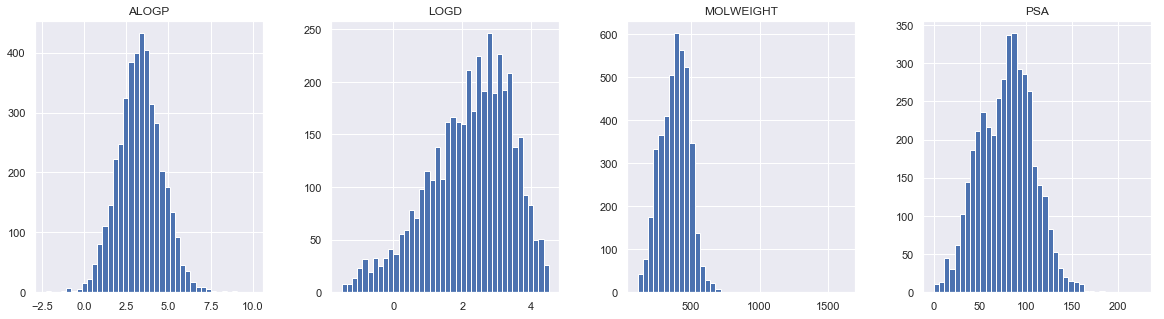

In [7]:
# Visualize the distributions of compound properties in the data set
logd_df.hist(bins=40, layout=(1,4), figsize=(20,5));

In [8]:
# Regarding the molecular weight, we see some extreme cases in the data set, so let's have a look
high_mw_cpds_logd = logd_df[logd_df.MOLWEIGHT > 900] # All compounds with molweight > 900
high_mw_cpds_logd

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,LOGD,RDKIT_MOL
147,CHEMBL1200558,BACITRACIN,1422.72,NaN,NaN,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,-0.46,<rdkit.Chem.rdchem.Mol object at 0x1225ef170>
1099,CHEMBL443684,NAVITOCLAX,974.63,8.83,128.36,CC1(C)CCC(=C(CN2CCN(CC2)c3ccc(cc3)C(=O)NS(=O)(...,0.64,<rdkit.Chem.rdchem.Mol object at 0x1a25ab5800>
1503,CHEMBL387675,DAPTOMYCIN,1620.69,NaN,NaN,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,-0.94,<rdkit.Chem.rdchem.Mol object at 0x1a25abd940>
2808,CHEMBL2170837,NaN,1065.70,NaN,NaN,CCn1c(C)c(C(=O)O)c(c2cccc(c2)N3CCN(CC3)c4ccc(N...,4.20,<rdkit.Chem.rdchem.Mol object at 0x1a25ad7ad0>


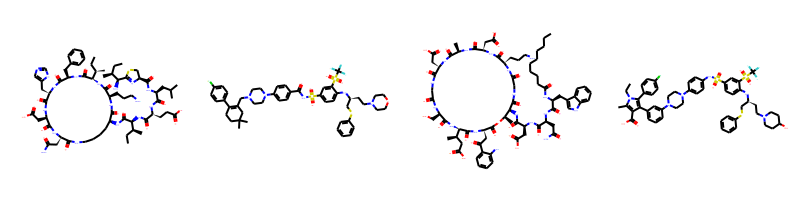

In [9]:
# Visualize these compounds
high_mw_cpds_logd_mols = list(high_mw_cpds_logd.RDKIT_MOL)
img = Chem.Draw.MolsToGridImage(high_mw_cpds_logd_mols, molsPerRow=4, useSVG=True )
img # Draw the molecules

Two of them are large circular polypeptide/lipopeptide antibiotics (Bacitran and Daptomycin).

One of them is a large but orally available experimental anti-cancer agent (Navitoclax)

In [10]:
# Check if all values for logD are within experimental range as reported (-1.5 to 4.5)
print ("Observed values for logD in dataset between {} (expected: -1.5) and {} (expected 4.5)".format(logd_df.LOGD.min(), logd_df.LOGD.max()))

Observed values for logD in dataset between -1.5 (expected: -1.5) and 4.5 (expected 4.5)


### Modeling of lipophilicity

The lipophilicity (logD) of the compounds will be modeled using a stochastic gradient boosting regressor

In [11]:
# First, calculcate Morgan circular chemical structure fingerprints for all compounds
logd_fps = logd_df.apply(lambda x: np.array(AllChem.GetMorganFingerprintAsBitVect(x['RDKIT_MOL'], 2)), axis=1)
logd_fps_df = pd.DataFrame(logd_fps.values.tolist(), index=logd_df['CMPD_CHEMBLID'])

In [12]:
# Split up the logD data set intro training and test set for modeling
# We'll use 20 % of the data set for testing and 80 % for training (stratified sampling)
X_train_logD, X_test_logD, y_train_logD, y_test_logD = train_test_split(logd_fps_df, logd_df.LOGD, test_size=0.2, random_state=1)

In [63]:
# Train the model
clf_logd = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=0.05, subsample=0.4)
scores = cross_val_score(clf_logd, X_train_logD, y_train_logD, cv=3, scoring='r2')

In [64]:
# Evaluate cross-validation performance on training set
print("The mean coefficient of correlation for the training set (3 times CV) is {}.".format(round(scores.mean(),2)))

The mean coefficient of correlation for the training set (3 times CV) is 0.47.


In [65]:
# Fit the model again to the complete training set
clf_logd.fit(X_train_logD, y_train_logD);

In [69]:
# Predict values for the test set and evaluate the predictive performance
y_predict_train_logD = clf_logd.predict(X_train_logD)
y_predict_test_logD = clf_logd.predict(X_test_logD)
scores_test = r2_score(y_test_logD, y_predict_test_logD)
print("The correlation for the test set is {}.".format(round(scores_test,2)))

The correlation for the test set is 0.45.


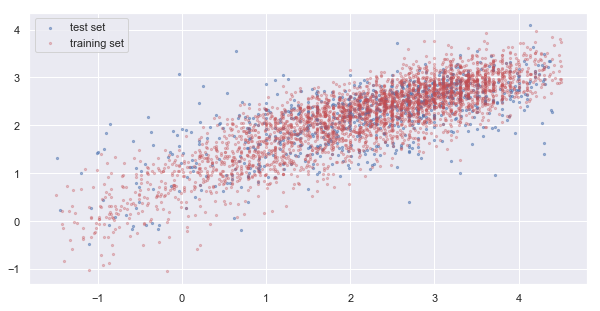

In [77]:
# Let's plot the predictions and the ground-truth values
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test_logD, y_predict_test_logD, s=5, c='b', alpha=0.5, label='test set')
ax1.scatter(y_train_logD, y_predict_train_logD, s=5, c='r', alpha=0.3, label='training set')
plt.legend(loc='upper left');
plt.show()

In [87]:
absolute_mean_error_test_logd = np.mean(abs(y_test_logD-y_predict_test_logD))
print("The mean absolute error on the test set for logD predictions is {}".format(round(absolute_mean_error_test_logd, 2)))

The mean absolute error on the test set for logD predictions is 0.67


## Analysis of hPPB data set

### Data extraction

In [93]:
# Read in data frame
hppb_df_raw = pd.read_csv('./data/CHEMBL3301365_dataset.tsv', sep='\t')
# Extract relevant columns
hppb_df = hppb_df_raw[['CMPD_CHEMBLID', 'MOL_PREF_NAME', 'MOLWEIGHT', 'ALOGP', 'PSA', 'CANONICAL_SMILES', 'STANDARD_VALUE']]
# `STANDARD_VALUE` here is percentage bound to human plasma, rename
hppb_df = hppb_df.rename(index=str, columns={'STANDARD_VALUE': 'PERC_PLASMA_BOUND'})

### Exploratory analysis

In [94]:
print("The dataset has {} entries.".format(hppb_df.shape[0]))
print("{} unique values for the ChEMBL ID, thus no duplicates.".format(hppb_df['CMPD_CHEMBLID'].nunique()))
print("Are there any missing values for the measures property (% plasma bound) ? -> {}".format(hppb_df.PERC_PLASMA_BOUND.isnull().any()))

The dataset has 1614 entries.
1614 unique values for the ChEMBL ID, thus no duplicates.
Are there any missing values for the measures property (% plasma bound) ? -> False


In [95]:
# Let's have a look at the data 
hppb_df.head()

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,PERC_PLASMA_BOUND
0,CHEMBL644,TRIMIPRAMINE,294.44,4.12,6.48,CC(CN(C)C)CN1c2ccccc2CCc3ccccc13,93.10
1,CHEMBL297685,NaN,351.39,2.41,89.85,Cn1c(nc2c(N)nc(nc12)C#CC3(O)CCCC3)c4cccc(F)c4,88.11
2,CHEMBL1090488,PF-00446687,470.60,4.78,43.78,C[C@@H]1CN(C[C@H](C)[C@@]1(O)c2ccccc2)C(=O)[C@...,76.81
3,CHEMBL1092240,NaN,475.54,3.87,127.79,[O-][N+](=O)c1c(Nc2ccc(cc2)n3cncn3)ncnc1N4CCC(...,99.83
4,CHEMBL1096418,NaN,360.83,2.58,90.01,Nc1scc2C(=NN(C(=O)c12)c3ccc(Cl)cc3)C(=O)NC4CC4,98.21


In [96]:
# Compute rdkit molecules from canonical SMILES (needed later for calculcation of additional properties)
hppb_df['RDKIT_MOL']=hppb_df.apply(lambda x: Chem.MolFromSmiles(x['CANONICAL_SMILES']), axis=1)

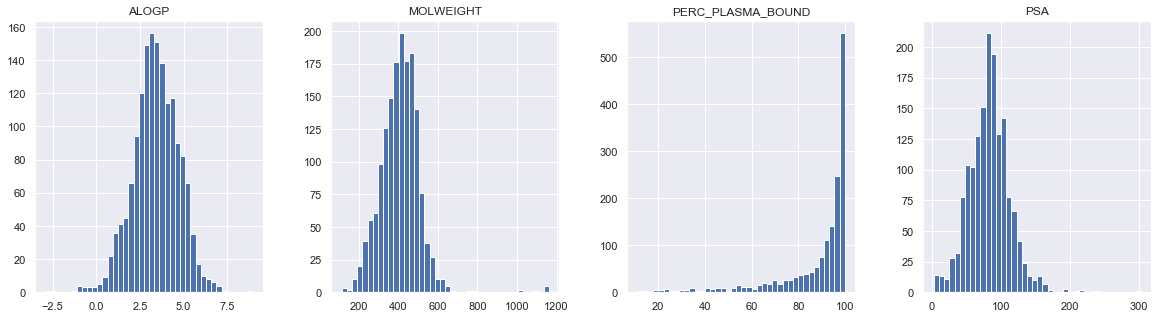

In [97]:
# Visualize the distributions of compound properties in the data set
hppb_df.hist(bins=40, layout=(1,4), figsize=(20,5));

In [98]:
# Regarding the molecular weight, we see some extreme cases in the data set, so let's have a look
high_mw_cpds_hppb = hppb_df[hppb_df.MOLWEIGHT > 900] # All compounds with molweight > 900
high_mw_cpds_hppb

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,PERC_PLASMA_BOUND,RDKIT_MOL
110,CHEMBL1090941,NaN,1160.43,NaN,NaN,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([C@@H](C)...,88.82,<rdkit.Chem.rdchem.Mol object at 0x1a25872580>
1023,CHEMBL1090940,NaN,1159.45,NaN,NaN,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H](C)C(=O)N[...,92.32,<rdkit.Chem.rdchem.Mol object at 0x1a25884990>
1024,CHEMBL1091291,NaN,1159.45,NaN,NaN,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([C@@H](C)...,94.19,<rdkit.Chem.rdchem.Mol object at 0x1a258849e0>
1025,CHEMBL1091678,DEACYL POLYMYXIN B,1105.31,NaN,NaN,CC(C)C[C@@H]1NC(=O)[C@@H](Cc2ccccc2)NC(=O)[C@H...,64.54,<rdkit.Chem.rdchem.Mol object at 0x1a25884a30>
1113,CHEMBL2070241,BREMELANOTIDE,1025.18,NaN,NaN,CCCC[C@H](NC(=O)C)C(=O)N[C@H]1CC(=O)NCCCC[C@H]...,27.09,<rdkit.Chem.rdchem.Mol object at 0x1a25886670>
1122,CHEMBL1090630,NaN,1160.43,NaN,NaN,CCCCCCCC(=O)N[C@@H](C)C(=O)N[C@@H]([C@@H](C)O)...,89.27,<rdkit.Chem.rdchem.Mol object at 0x1a25886940>
1225,CHEMBL1091289,NaN,1160.43,NaN,NaN,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([C@@H](C)...,86.85,<rdkit.Chem.rdchem.Mol object at 0x1a25888a30>
1478,CHEMBL430239,MELATONAN,1024.20,NaN,NaN,CCCC[C@H](NC(=O)C)C(=O)N[C@H]1CC(=O)NCCCC[C@H]...,55.73,<rdkit.Chem.rdchem.Mol object at 0x1a2588db20>


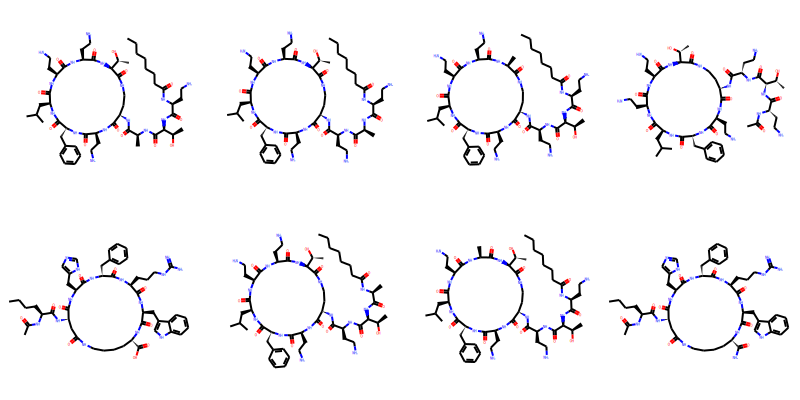

In [99]:
# Visualize these compounds
high_mw_cpds_hppb_mols = list(high_mw_cpds_hppb.RDKIT_MOL)
img = Chem.Draw.MolsToGridImage(high_mw_cpds_hppb_mols, molsPerRow=4, useSVG=True )
img # Draw the molecules

Again, as for the logD data set, we have high molecular weight compounds from the class of circular polypeptides/lipopeptides

In [100]:
# Regarding the molecular weight, we see some extreme cases in the data set, so let's have a look
high_psa_cpds_hppb = hppb_df[hppb_df.PSA > 200] # All compounds with PSA > 200
high_psa_cpds_hppb

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,PERC_PLASMA_BOUND,RDKIT_MOL
5,CHEMBL1096896,UK432097,777.89,1.92,220.78,CCNC(=O)[C@H]1O[C@H]([C@H](O)[C@@H]1O)n2cnc3c(...,99.10,<rdkit.Chem.rdchem.Mol object at 0x1a25a85300>
667,CHEMBL34259,METHOTREXATE,454.45,0.27,210.54,CN(Cc1cnc2nc(N)nc(N)c2n1)c3ccc(cc3)C(=O)N[C@@H...,46.55,<rdkit.Chem.rdchem.Mol object at 0x1a2587d7b0>
717,CHEMBL2021696,NaN,654.60,-2.90,303.36,CN1C(=O)N(N=C1C2=CC(=O)C(=CN2)O)S(=O)(=O)NC(=O...,95.53,<rdkit.Chem.rdchem.Mol object at 0x1a2587e7b0>
1102,CHEMBL1256967,NaN,518.49,-1.41,235.97,CC1(C)[C@H](NC(=O)\C(=N/OCC2=CC(=O)C(=CN2O)O)\...,69.12,<rdkit.Chem.rdchem.Mol object at 0x1a25886300>
1455,CHEMBL507674,CEFOPERAZONE,645.68,-1.11,220.26,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...,90.12,<rdkit.Chem.rdchem.Mol object at 0x1a2588d3f0>


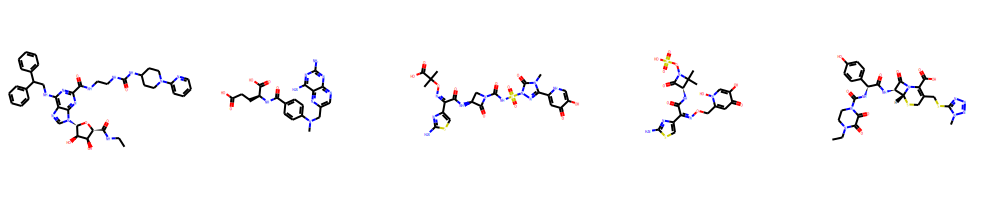

In [101]:
# Visualize these compounds
high_psa_cpds_hppb_mols = [Chem.MolFromSmiles(smiles) for smiles in high_psa_cpds_hppb.CANONICAL_SMILES]
img = Chem.Draw.MolsToGridImage(high_psa_cpds_hppb_mols, molsPerRow=5, useSVG=True )
img # Draw the molecules

Five compounds in this dataset are highly polar (PSA > 200), including the approved drug methotrexate

In [102]:
# Check if all values for human plasma binding are within experimental range as reported (10 % to 99.5 %)
print ("Observed values for human plasma binding in dataset between {} % (expected: 10 %) and {} % (expected 99.5 %)".format(hppb_df.PERC_PLASMA_BOUND.min(), hppb_df.PERC_PLASMA_BOUND.max()))
# Slight discrepancy for minumum value, but maybe the range given indicated the values which can be measures in the assay
#@TODO Clarify with investigator

Observed values for human plasma binding in dataset between 11.18 % (expected: 10 %) and 99.95 % (expected 99.5 %)


### Modeling of human plasma protein binding

The human plasma binding of the compounds will be modeled using a regression model with a stochastic gradient boosting regressor

In [103]:
# First, calculcate Morgan circular chemical structure fingerprints for all compounds
hppb_fps = hppb_df.apply(lambda x: np.array(AllChem.GetMorganFingerprintAsBitVect(x['RDKIT_MOL'], 2)), axis=1)
hppb_fps_df = pd.DataFrame(hppb_fps.values.tolist(), index=hppb_df['CMPD_CHEMBLID'])

In [268]:
# Split up the logD data set intro training and test set for modeling
# We'll use 10 % of the data set for testing and 90 % for training (stratified sampling)
X_train_hppb, X_test_hppb, y_train_hppb, y_test_hppb = train_test_split(hppb_fps_df, hppb_df.PERC_PLASMA_BOUND, test_size=0.1, random_state=2)

In [313]:
# Train the model
clf_hppb = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=0.01, subsample=0.6)
scores_hppb = cross_val_score(clf_hppb, X_train_hppb, y_train_hppb, cv=3, scoring='neg_mean_absolute_error')

In [314]:
# Evaluate cross-validation performance on training set
print("The mean absolute error for the training set (3 times CV) is {}.".format(round(abs(scores_hppb.mean()),2)))

The mean absolute error for the training set (3 times CV) is 10.14.


In [315]:
# Fit the model again to the complete training set
clf_hppb.fit(X_train_hppb, y_train_hppb);

In [316]:
# Predict values for the test set and evaluate the predictive performance
y_predict_train_hppb = clf_hppb.predict(X_train_hppb)
y_predict_test_hppb = clf_hppb.predict(X_test_hppb)
scores_test_hppb = mean_absolute_error(y_test_hppb, y_predict_test_hppb)
print("The mean absolute error for the test set is {}.".format(round(scores_test_hppb,2)))

The mean absolute error for the test set is 10.93.


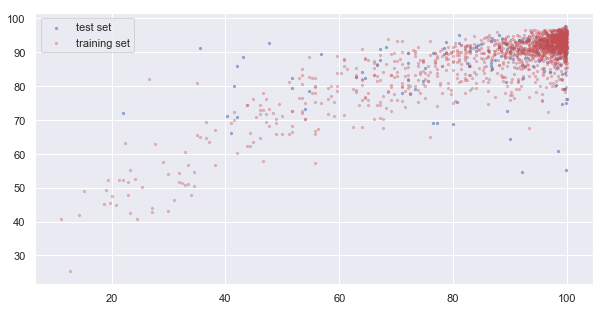

In [317]:
# Let's plot the predictions and the ground-truth values
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test_hppb, y_predict_test_hppb, s=5, c='b', alpha=0.5, label='test set')
ax1.scatter(y_train_hppb, y_predict_train_hppb, s=5, c='r', alpha=0.3, label='training set')
plt.legend(loc='upper left');
plt.show()

## Outlook: Application

* data sets are merged
* missing values for logD and human plasma binding predicted with the models
* top 10 candidates for potential CNS drug discovery project prioritized

In [429]:
# Check the overlap between the two sets
size_overlap_datasets = len(set(logd_df.CMPD_CHEMBLID).intersection(set(hppb_df.CMPD_CHEMBLID)))
size_only_in_logd = len(set(logd_df.CMPD_CHEMBLID).difference(set(hppb_df.CMPD_CHEMBLID)))
size_only_in_hppb = len(set(hppb_df.CMPD_CHEMBLID).difference(set(logd_df.CMPD_CHEMBLID)))
print("Of the two analyzed datasets, there is both logD and hPPB data for {} compounds".format(size_overlap_datasets))
print("Prediction of logD data necessary for {} compounds".format(size_only_in_hppb))
print("Prediction of hPPB data necessary for {} compounds".format(size_only_in_logd))

Of the two analyzed datasets, there is both logD and hPPB data for 1008 compounds
Prediction of logD data necessary for 606 compounds
Prediction of hPPB data necessary for 3192 compounds


In [375]:
# Combine data frames
merged_df = logd_df.merge(hppb_df[['CMPD_CHEMBLID', 'PERC_PLASMA_BOUND']], on='CMPD_CHEMBLID', how='outer')

In [390]:
# For all missing values of logD and human plasma binding in the combined dataset, predict values using the models
merged_df['LOGD'] = merged_df.apply(lambda row: clf_logd.predict(np.array(hppb_fps_df.loc[row['CMPD_CHEMBLID']]).reshape(1,-1))[0] if np.isnan(row['LOGD']) else row['LOGD'], axis=1)
merged_df['PERC_PLASMA_BOUND'] = merged_df.apply(lambda row: clf_hppb.predict(np.array(logd_fps_df.loc[row['CMPD_CHEMBLID']]).reshape(1,-1))[0] if np.isnan(row['PERC_PLASMA_BOUND']) else row['PERC_PLASMA_BOUND'], axis=1)

In [439]:
# For the following scenario, use the new data to prioritize drug candidates
# Select CNS (central nervous system) drug candidates with the following properties
high_plasma_binding = (merged_df['PERC_PLASMA_BOUND'] > 70) & (merged_df['PERC_PLASMA_BOUND'] < 95)
moderate_low_lipophilicity = (merged_df['LOGD'] > 0) & (merged_df['LOGD'] < 3)
low_mw = (merged_df['MOLWEIGHT'] < 400)
candidates = high_plasma_binding & moderate_low_lipophilicity & low_mw

# Best 100 candidates for a potential CNS drug discovery projects
# High plasma protein binding, moderately low lipophilicity.
# Molecular weight lower than 400
# Selected out of these e.g. the 10 lowest MW compounds for prioritized testing or development
top10_candidates = merged_df[candidates].sort_values('MOLWEIGHT').head(10)
top10_candidates

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,LOGD,RDKIT_MOL,PERC_PLASMA_BOUND
381,CHEMBL86795,INDAZOLE,118.14,1.56,28.68,c1ccc2[nH]ncc2c1,1.90,<rdkit.Chem.rdchem.Mol object at 0x1a25aa7260>,91.298125
452,CHEMBL59925,NaN,122.17,1.28,38.91,Cc1cc(C)nc(N)c1,0.85,<rdkit.Chem.rdchem.Mol object at 0x1a25aa88f0>,72.359651
3439,CHEMBL158766,NaN,124.14,1.41,40.46,Cc1ccc(O)c(O)c1,1.37,<rdkit.Chem.rdchem.Mol object at 0x1a25ae44e0>,91.913323
3249,CHEMBL14474,QUINOLINE,129.16,2.23,12.89,c1ccc2ncccc2c1,2.09,<rdkit.Chem.rdchem.Mol object at 0x1a25ae0800>,91.449104
1053,CHEMBL12315,ISOQUINOLINE,129.16,2.23,12.89,c1ccc2cnccc2c1,1.60,<rdkit.Chem.rdchem.Mol object at 0x1a25ab4940>,91.446226
2063,CHEMBL301359,QUINAZOLINE,130.15,1.63,25.78,c1ccc2ncncc2c1,1.00,<rdkit.Chem.rdchem.Mol object at 0x1a25ac8c60>,91.449104
2134,CHEMBL450643,NaN,130.15,1.63,25.78,c1cnc2cccnc2c1,0.89,<rdkit.Chem.rdchem.Mol object at 0x1a25aca350>,91.215536
3320,CHEMBL1331627,NaN,133.15,1.15,54.70,Nc1[nH]nc2ccccc12,1.00,<rdkit.Chem.rdchem.Mol object at 0x1a25ae1e90>,89.318527
2204,CHEMBL594707,NaN,133.15,1.15,54.70,Nc1ccc2cn[nH]c2c1,0.52,<rdkit.Chem.rdchem.Mol object at 0x1a25acb990>,86.699037
4046,CHEMBL356894,NaN,134.14,0.54,67.59,Nc1ncnc2[nH]ccc12,1.78,<rdkit.Chem.rdchem.Mol object at 0x1a25af0710>,87.676686


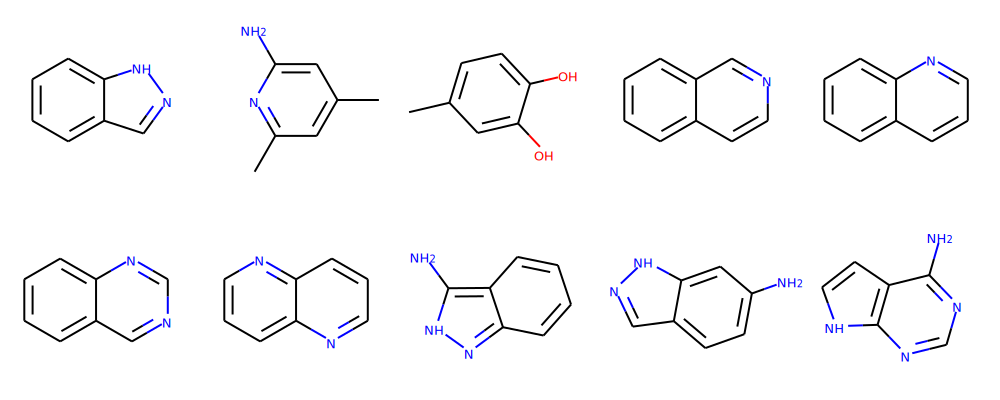

In [434]:
# Visualize these compounds
top10_cns_candidates = list(top10_candidates.RDKIT_MOL)
img = Chem.Draw.MolsToGridImage(top10_cns_candidates, molsPerRow=5, useSVG=True )
img # Draw the molecules

For a CNS drug discovery or development project, the prioritized compound list above shows the top 10 compounds (sorted by molecular weight) with the following properties:

* MW < 400
* human plasma protein binding between 70 and 95 %
* logD between 0 and 3

These compounds are very small and could be used as starting points for med. chem. development

In [442]:
print("In total, there are {} compound candidates with these properties".format(merged_df[candidates].shape[0]))

In total, there are 1245 compound candidates with these properties


In [445]:
# Finally, let's get a random sample from the complete list of candidates
random10_candidates = merged_df[candidates].sample(10)
random10_candidates

,CMPD_CHEMBLID,MOL_PREF_NAME,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,LOGD,RDKIT_MOL,PERC_PLASMA_BOUND
3818,CHEMBL1545465,NaN,313.35,3.02,59.75,COc1ccc(cc1)C(=O)C2CCN(CC2)C(=O)c3occc3,2.42,<rdkit.Chem.rdchem.Mol object at 0x1a25aebdf0>,87.226258
72,CHEMBL135400,ZOPICLONE,388.82,1.57,91.76,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,1.10,<rdkit.Chem.rdchem.Mol object at 0x12291d080>,76.231177
301,CHEMBL36643,NaN,304.28,2.02,77.52,COC(=O)COc1ccc(cn1)C(=O)Nc2ccc(F)cc2,2.43,<rdkit.Chem.rdchem.Mol object at 0x1a25aa58a0>,89.259642
464,CHEMBL1322675,NaN,341.45,3.24,58.56,CCCNC[C@H](O)COc1ccccc1C(=O)CCc2ccccc2,1.69,<rdkit.Chem.rdchem.Mol object at 0x1a25aa8cb0>,86.424196
2060,CHEMBL1199988,NaN,360.42,3.26,94.79,Nc1ncc(cc1c2oc3ccccc3n2)c4cnn(c4)C5CCNCC5,1.85,<rdkit.Chem.rdchem.Mol object at 0x1a25ac8b70>,90.635854
700,CHEMBL61946,CARAMIPHEN,289.42,3.38,29.54,CCN(CC)CCOC(=O)C1(CCCC1)c2ccccc2,2.30,<rdkit.Chem.rdchem.Mol object at 0x1a25aad850>,74.327475
3549,CHEMBL578723,NaN,224.26,2.98,48.14,COc1ccc2nc3ccccc3c(N)c2c1,1.00,<rdkit.Chem.rdchem.Mol object at 0x1a25ae6800>,89.280449
3585,CHEMBL492234,NaN,392.46,2.50,94.47,COC(=O)c1ccc(C)c(NS(=O)(=O)c2ccc3N(C)SC(=O)c3c...,2.60,<rdkit.Chem.rdchem.Mol object at 0x1a25ae73a0>,91.259010
2931,CHEMBL403877,NaN,395.39,1.37,123.76,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc3NC(=O)C(=O)Nc13,2.48,<rdkit.Chem.rdchem.Mol object at 0x1a25ada260>,92.925223
1917,CHEMBL1194666,DIETHYLPROPION,205.30,2.60,20.31,CCN(CC)C(C)C(=O)c1ccccc1,1.18,<rdkit.Chem.rdchem.Mol object at 0x1a25ac5da0>,88.891008


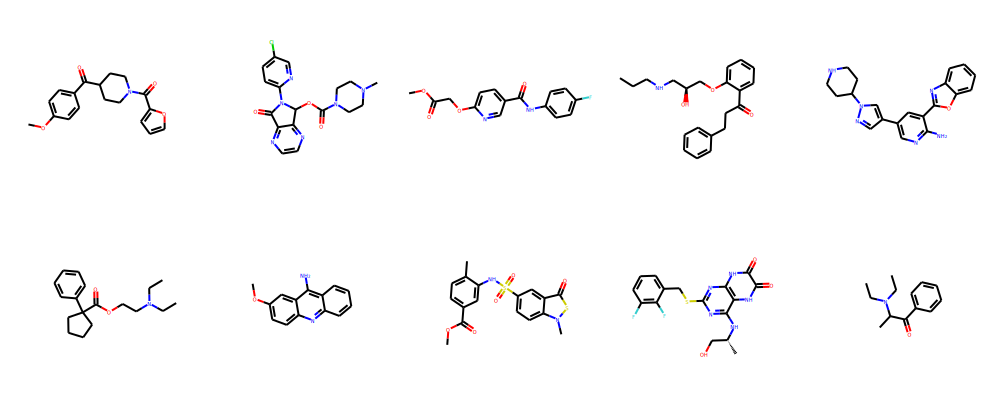

In [446]:
# Visualize these compounds
random10_cns_candidates = list(random10_candidates.RDKIT_MOL)
img = Chem.Draw.MolsToGridImage(random10_cns_candidates, molsPerRow=5, useSVG=True )
img # Draw the molecules

Among them, there are known CNS drugs such as the hypnotic agent zopiclone and the appetite depressant diethylpropion, which has known activating influence on the CNS system as a side effect.